In [1]:
import pandas as pd
import os
import re

In [2]:
data = pd.read_csv('../datasets/train.txt', sep='\t', header=None, names=['Title', 'Origin', 'Genre', 'Director', 'Plot'])

print("Genre value counts")
print(data['Genre'].value_counts())

Genre value counts
Genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        214
Name: count, dtype: int64


In [3]:
data.head()

,Title,Origin,Genre,Director,Plot
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...
3,Gang,Bollywood,crime,Mazhar Khan,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Intimate Relations,British,drama,Charles Frank,Crisis in a middle-class family when the son f...


In [4]:
def preprocess_text(text):
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

data['Clean_Plot'] = data['Plot'].apply(preprocess_text)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_42062/797431882.py:3: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


# BERT

In [5]:
!pip install transformers
!pip install torch

In [11]:
import torch
from transformers import DistilBertTokenizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
# for the love of God use GPU for training (output should be "Using device: cuda")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
encoder = LabelEncoder()
data['GenreEncoded'] = encoder.fit_transform(data['Genre'])

X_train, X_test, y_train, y_test = train_test_split(
    data['Clean_Plot'], data['GenreEncoded'], 
    test_size=0.2, 
    random_state=42, 
    stratify=data['GenreEncoded']
)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("done")

done


In [9]:
## OLD VERSION

#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

#def tokenize_data(texts, max_length=512):
#    return tokenizer(
#        texts.tolist(),
#        padding=True,
#        truncation=True,
#        max_length=max_length,
#        return_tensors='pt'
#    )

#train_encodings = tokenize_data(X_train)
#test_encodings = tokenize_data(X_test)


In [ ]:
# NEW VERSION OF ENCODINGS THAT MERGE CHUNKS

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def chunk_text(text, max_length=512):
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

def tokenize_chunked_data(texts, labels, max_length=512):
    all_chunks = []
    all_labels = []
    for i, text in enumerate(texts):
        chunks = chunk_text(text, max_length)
        all_chunks.extend(chunks)
        all_labels.extend([labels[i]] * len(chunks))
    encodings = tokenizer(all_chunks, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    return encodings, all_labels

train_encodings, train_labels = tokenize_chunked_data(X_train, y_train)
test_encodings, test_labels = tokenize_chunked_data(X_test, y_test)

In [46]:
print(len(train_encodings['input_ids']), len(train_labels))
print(len(test_encodings['input_ids']), len(test_labels))

assert len(train_encodings['input_ids']) == len(train_labels), "Mismatch between encodings and labels"
assert len(test_encodings['input_ids']) == len(test_labels), "Mismatch between encodings and labels"

8652 8652
2190 2190


In [47]:
# just to visualize an embedding example
input_ids = train_encodings['input_ids'][0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['[CLS]', '18', '-', 'year', '-', 'old', 'joy', 'starts', 'her', 'catalogue', 'of', 'bad', 'choices', 'by', 'running', 'away', 'from', 'home', 'with', 'tom', '.', 'they', 'marry', 'and', 'have', 'a', 'son', ',', 'johnny', '.', 'when', 'tom', ',', 'a', 'thief', 'who', 'mentally', 'and', 'physically', 'abuses', 'joy', ',', 'is', 'jailed', 'for', 'four', 'years', 'after', 'attempting', 'a', 'big', 'robbery', ',', 'she', 'is', 'left', 'on', 'her', 'own', 'with', 'their', 'son', '.', 'after', 'briefly', 'sharing', 'a', 'room', 'with', 'her', 'aunt', 'em', '##m', ',', 'an', 'aging', 'prostitute', ',', 'she', 'moves', 'in', 'with', 'dave', ',', 'one', 'of', 'tom', "'", 's', 'former', 'associates', '.', 'dave', 'is', 'tender', 'and', 'understanding', 'in', 'his', 'treatment', 'of', 'johnny', 'and', 'joy', ',', 'but', 'the', 'id', '##yl', '##l', 'is', 'pun', '##cture', '##d', 'when', 'dave', 'gets', '12', 'years', 'for', 'robbery', '.', 'intending', 'to', 'be', 'faithful', ',', 'joy', 'writes',

## Custom Dataset Class

In [48]:
class MovieGenreDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
train_dataset = MovieGenreDataset(train_encodings, train_labels)
test_dataset = MovieGenreDataset(test_encodings, test_labels)

## Compute Class Weights and Loss Function

In [ ]:
# TODO this isn't being used, not sure if it even makes sense to use

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), # TODO train_labels?
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# TODO add class_weights?

def custom_loss_fn(outputs, labels):
    loss_fct = nn.CrossEntropyLoss(weight=class_weights)
    return loss_fct(outputs.view(-1, num_labels), labels.view(-1))


In [50]:
from transformers import DistilBertForSequenceClassification

num_labels = len(encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=num_labels)

#model = BertForSequenceClassification.from_pretrained('bert-base-uncased'), num_labels=num_labels)

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [51]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    print(f"Accuracy: {acc}, F1-score: {f1}")
    return {'accuracy': acc, 'f1': f1}

## Training

In [52]:
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

os.environ["WANDB_DISABLED"] = "true" # WANDB kept asking me for a key or something, so this shuts him up

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=100,
    logging_dir='./logs',
    gradient_accumulation_steps=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,1.138900,0.991587,0.648402,0.634218
2,0.597700,0.869265,0.706393,0.701964
4,0.388800,0.869127,0.707763,0.706076


Accuracy: 0.6484018264840182, F1-score: 0.6342178615534165
Accuracy: 0.6972602739726027, F1-score: 0.6909479091423981
Accuracy: 0.7063926940639269, F1-score: 0.701964262956326
Accuracy: 0.7105022831050228, F1-score: 0.7098903216607828
Accuracy: 0.7077625570776256, F1-score: 0.706076095711429


TrainOutput(global_step=1350, training_loss=0.7229989680537471, metrics={'train_runtime': 1289.6881, 'train_samples_per_second': 33.543, 'train_steps_per_second': 1.047, 'total_flos': 5721186259058688.0, 'train_loss': 0.7229989680537471, 'epoch': 4.990757855822551})

## Evaluation Metrics (Accuracy, F1)

In [53]:
eval_result = trainer.evaluate()
print(f"Evaluation Results: {eval_result}")

Accuracy: 0.7077625570776256, F1-score: 0.706076095711429
Evaluation Results: {'eval_loss': 0.8691269159317017, 'eval_accuracy': 0.7077625570776256, 'eval_f1': 0.706076095711429, 'eval_runtime': 20.5843, 'eval_samples_per_second': 106.392, 'eval_steps_per_second': 6.656, 'epoch': 4.990757855822551}


## Confusion Matrix

Accuracy: 0.7077625570776256, F1-score: 0.706076095711429


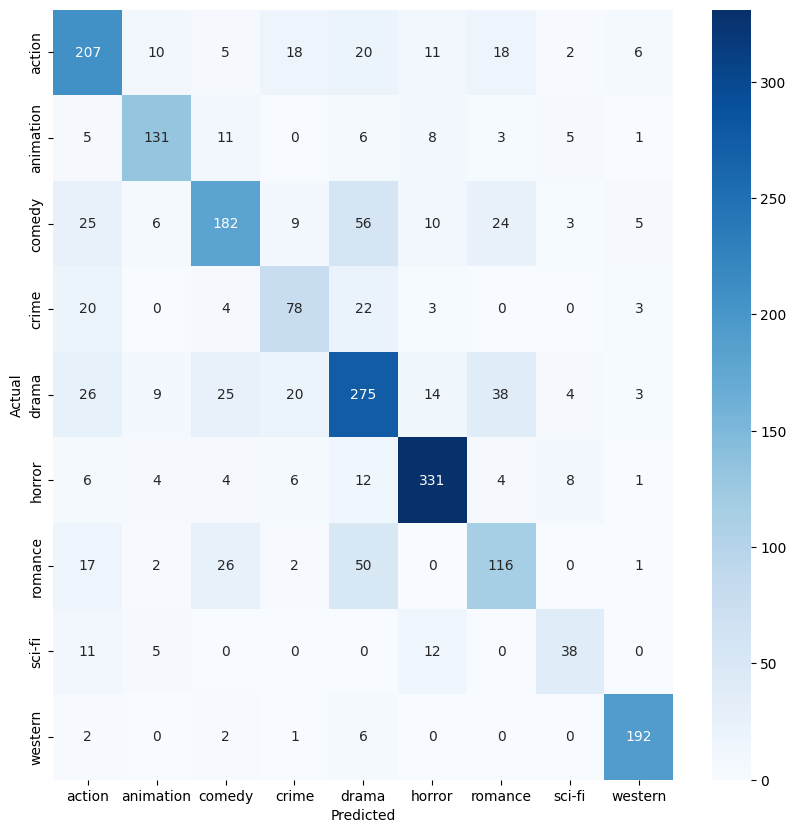

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return cm
    
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = test_dataset.labels
cm = plot_confusion_matrix(true_labels, predicted_labels, encoder.classes_)

In [57]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[207  10   5  18  20  11  18   2   6]
 [  5 131  11   0   6   8   3   5   1]
 [ 25   6 182   9  56  10  24   3   5]
 [ 20   0   4  78  22   3   0   0   3]
 [ 26   9  25  20 275  14  38   4   3]
 [  6   4   4   6  12 331   4   8   1]
 [ 17   2  26   2  50   0 116   0   1]
 [ 11   5   0   0   0  12   0  38   0]
 [  2   0   2   1   6   0   0   0 192]]


## Manually Analyze Misclassifications

In [1]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]

for idx in misclassified_indices[:10]:  # Displaying first 10 misclassified examples
    print(f"True label: {encoder.inverse_transform([true_labels[idx]])[0]}, Predicted: {encoder.inverse_transform([predicted_labels[idx]])[0]}")
    print(f"Text: {X_test.iloc[idx]}")
    print("-" * 50)

NameError: name 'np' is not defined